<a href="https://colab.research.google.com/github/hubbysmall/public_notebooks/blob/master/fraud_detection_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer
from sklearn.model_selection import KFold
import random
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
train_trans = pd.read_csv('drive/My Drive/fraud_det/train_transaction.csv', index_col =False)
train_identity = pd.read_csv('drive/My Drive/fraud_det/train_identity.csv', index_col =False)

# test_trans = pd.read_csv('drive/My Drive/fraud_det/test_transaction.csv', index_col =False)
# test_identity = pd.read_csv('drive/My Drive/fraud_det/test_identity.csv', index_col =False)

result_train = pd.merge(train_trans, train_identity, left_on='TransactionID', right_on='TransactionID', how='left')
# result_test = pd.merge(test_trans, test_identity, left_on='TransactionID', right_on='TransactionID', how='left')

del train_trans, train_identity

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

BASELINE MODEL

In [5]:
one_value_cols = [col for col in result_train.columns if result_train[col].nunique() <= 1]
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')

There are 0 columns in train dataset with one unique value.


In [6]:
result_train.replace([np.inf, -np.inf], np.nan)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.000,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,

In [0]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']
for col in cat_cols:
    if col in result_train.columns:
        lenc = LabelEncoder()
#         lenc.fit(list(X_train[col].astype(str).values) + list(X_test[col].astype(str).values))
        lenc.fit(list(result_train[col].astype(str).values))
        result_train[col] = lenc.transform(list(result_train[col].astype(str).values))
#         X_train[col] = lenc.transform(list(X_train[col].astype(str).values))
#         X_test[col] = lenc.transform(list(X_test[col].astype(str).values))

In [8]:
result_train = reduce_mem_usage(result_train, verbose=True)

Mem. usage decreased to 1763.89 Mb (10.0% reduction)


In [0]:
X = result_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = result_train.sort_values('TransactionDT')['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [7]:
model = lgb.LGBMClassifier()
start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

predictions = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

columns = X_train.columns 
columns

The baseline score on the test set is 0.9331.
The baseline training time is 61.0365 seconds


Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=431)

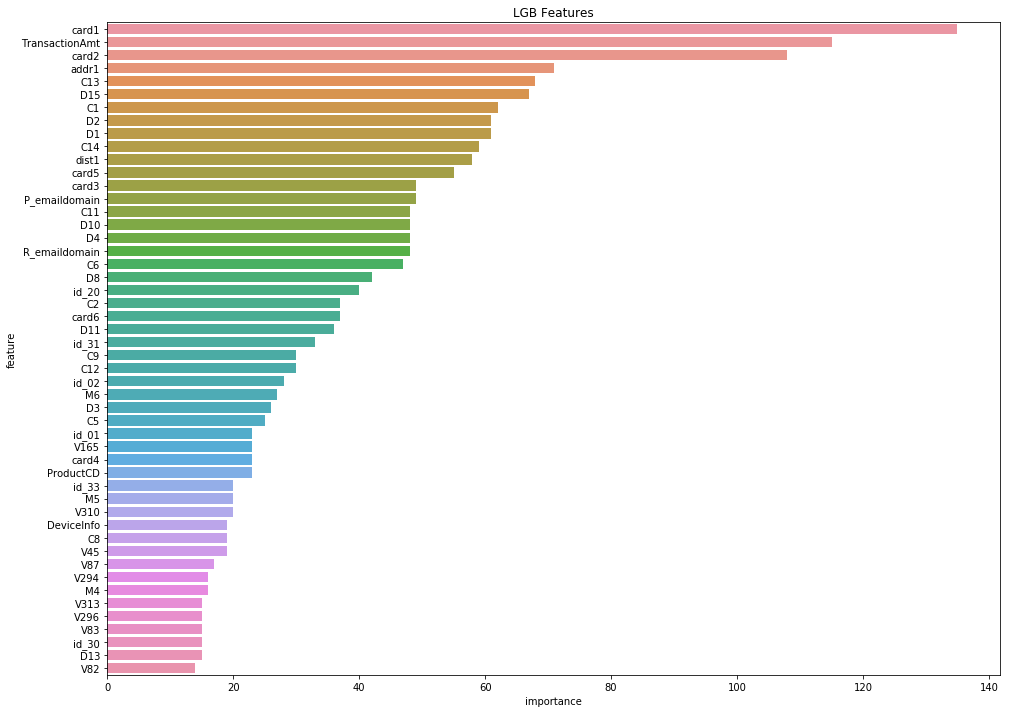

In [8]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = columns
feature_importance["importance"] = model.feature_importances_
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features');

HANDLING CARD INFORMATON

In [0]:
def check_if_null(val):
  if 'nan' in val:
    return np.nan
  return val


In [10]:
result_train_cards = result_train[['card1','card2','card3','card5','isFraud']]

cards = ['card1','card2','card3','card5','card1_card2','card1_card2_card3','card1_card2_card3_card5']

result_train_cards['card1_card2'] = result_train_cards['card1'].astype(str)+'_'+result_train_cards['card2'].astype(str)
result_train_cards['card1_card2_card3'] = result_train_cards['card1_card2'].astype(str)+'_'+result_train_cards['card3'].astype(str)
result_train_cards['card1_card2_card3_card5'] = result_train_cards['card1_card2_card3'].astype(str)+'_'+result_train_cards['card5'].astype(str)

result_train_cards['card1_card2'] = result_train_cards['card1_card2'].apply(lambda x: check_if_null(x) )
result_train_cards['card1_card2_card3'] = result_train_cards['card1_card2_card3'].apply(lambda x: check_if_null(x) )
result_train_cards['card1_card2_card3_card5'] = result_train_cards['card1_card2_card3_card5'].apply(lambda x: check_if_null(x) )

for col in cards:
  result_train_cards[col],_ = result_train_cards[col].factorize()

  
  
result_train_cards.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,card1,card2,card3,card5,isFraud,card1_card2,card1_card2_card3,card1_card2_card3_card5
0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1
2,2,2,0,2,0,2,2,2
3,3,3,0,3,0,3,3,3
4,4,4,0,1,0,4,4,4


In [11]:
X = result_train_cards.drop('isFraud', 1)
y = result_train_cards.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X.head()

,card1,card2,card3,card5,card1_card2,card1_card2_card3,card1_card2_card3_card5
0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,1
2,2,2,0,2,2,2,2
3,3,3,0,3,3,3,3
4,4,4,0,1,4,4,4


In [12]:
model = lgb.LGBMClassifier()
start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

predictions = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

columns = X_train.columns 
columns

The baseline score on the test set is 0.7914.
The baseline training time is 2.2310 seconds


Index(['card1', 'card2', 'card3', 'card5', 'card1_card2', 'card1_card2_card3',
       'card1_card2_card3_card5'],
      dtype='object')

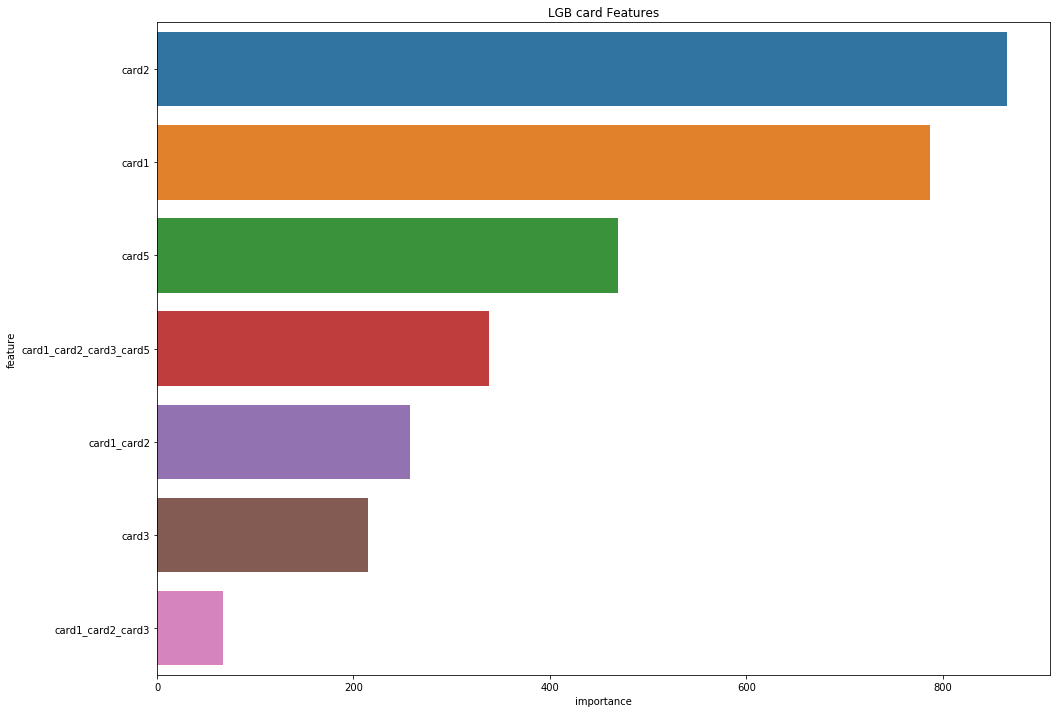

In [13]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = columns
feature_importance["importance"] = model.feature_importances_
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB card Features');

So new generated features: card1_card2_card3_card5 and card1_card2. card1,card2,card3,card5 here to stay

In [0]:
result_train['card1_card2'] = result_train['card1'].astype(str)+'_'+result_train['card2'].astype(str)
result_train['card1_card2_card3_card5'] = result_train['card1_card2'].astype(str)+'_'+result_train['card3'].astype(str) +'_'+result_train['card5'].astype(str)

result_train['card1_card2'] = result_train['card1_card2'].apply(lambda x: check_if_null(x) )
result_train['card1_card2_card3_card5'] = result_train['card1_card2_card3_card5'].apply(lambda x: check_if_null(x) )



In [0]:
del result_train_cards

SPLITTING FEATURES

In [9]:
result_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_card2,card1_card2_card3_card5
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755_404.0,2755_404.0_150.0_102.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4663_490.0,4663_490.0_150.0_166.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18132_567.0,18132_567.0_150.0_117.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497_514.0,4497_514.0_150.0_102.0


In [0]:
# ***********************id_30*********************

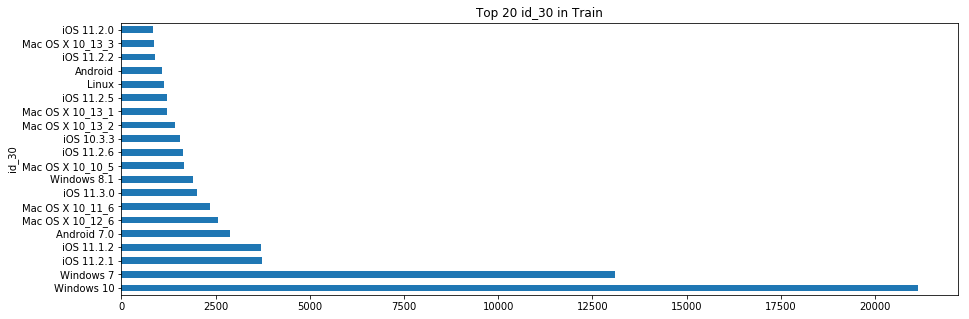

In [17]:
result_train.groupby('id_30') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 id_30 in Train')
plt.show()

In [18]:
result_train.id_30.unique()

array([nan, 'Android 7.0', 'iOS 11.1.2', 'Mac OS X 10_11_6', 'Windows 10',
       'Android', 'Linux', 'iOS 11.0.3', 'Mac OS X 10_7_5',
       'Mac OS X 10_12_6', 'Mac OS X 10_13_1', 'iOS 11.1.0',
       'Mac OS X 10_9_5', 'Windows 7', 'Windows 8.1', 'Mac', 'iOS 10.3.3',
       'Mac OS X 10.12', 'Mac OS X 10_10_5', 'Mac OS X 10_11_5',
       'iOS 9.3.5', 'Android 5.1.1', 'Android 7.1.1', 'Android 6.0',
       'iOS 10.3.1', 'Mac OS X 10.9', 'iOS 11.1.1', 'Windows Vista',
       'iOS 10.3.2', 'iOS 11.0.2', 'Mac OS X 10.11', 'Android 8.0.0',
       'iOS 10.2.0', 'iOS 10.2.1', 'iOS 11.0.0', 'Mac OS X 10.10',
       'Mac OS X 10_12_3', 'Mac OS X 10_12', 'Android 6.0.1', 'iOS',
       'Mac OS X 10.13', 'Mac OS X 10_12_5', 'Mac OS X 10_8_5',
       'iOS 11.0.1', 'iOS 10.0.2', 'Android 5.0.2', 'Windows XP',
       'iOS 11.2.0', 'Mac OS X 10.6', 'Windows 8', 'Mac OS X 10_6_8',
       'Mac OS X 10_11_4', 'Mac OS X 10_12_1', 'iOS 10.1.1',
       'Mac OS X 10_11_3', 'Mac OS X 10_12_4', 'Mac OS X 10

In [10]:
os = ['Windows','iOS','Android','Mac OS X','Linux','other', 'func']

s = "Android 6.0.1"
s2 = "Android"

r = "Mac OS X 10_14_1"
r2 = "Mac OS X"

l = "Linux"
l2 = "Linux"

print(s.split(s2))
print(r.split(r2))
print(l.split(l2))

['', ' 6.0.1']
['', ' 10_14_1']
['', '']


In [11]:
def separate_os(id_30text):
  if pd.isna(id_30text) == False:
    for el in os:
      if el in id_30text:
        return el
  return id_30text

def separate_osV(id_30text):
  if pd.isna(id_30text) == False:
    for el in os:
      if el in id_30text:
        split = id_30text.split(el)
        if split[1] != '':
          return split[1]
  return id_30text


result_train['os'] = result_train.id_30.apply(lambda x: separate_os(x) )
result_train['osV'] = result_train.id_30.apply(lambda x: separate_osV(x) )

result_train.os.unique(),result_train.osV.unique()

(array([nan, 'Android', 'iOS', 'Mac OS X', 'Windows', 'Linux', 'Mac',
        'func', 'other'], dtype=object),
 array([nan, ' 7.0', ' 11.1.2', ' 10_11_6', ' 10', 'Android', 'Linux',
        ' 11.0.3', ' 10_7_5', ' 10_12_6', ' 10_13_1', ' 11.1.0', ' 10_9_5',
        ' 7', ' 8.1', 'Mac', ' 10.3.3', ' 10.12', ' 10_10_5', ' 10_11_5',
        ' 9.3.5', ' 5.1.1', ' 7.1.1', ' 6.0', ' 10.3.1', ' 10.9',
        ' 11.1.1', ' Vista', ' 10.3.2', ' 11.0.2', ' 10.11', ' 8.0.0',
        ' 10.2.0', ' 10.2.1', ' 11.0.0', ' 10.10', ' 10_12_3', ' 10_12',
        ' 6.0.1', 'iOS', ' 10.13', ' 10_12_5', ' 10_8_5', ' 11.0.1',
        ' 10.0.2', ' 5.0.2', ' XP', ' 11.2.0', ' 10.6', ' 8', ' 10_6_8',
        ' 10_11_4', ' 10_12_1', ' 10.1.1', ' 10_11_3', ' 10_12_4',
        ' 10_13_2', ' 4.4.2', ' 10_12_2', ' 5.0', 'func', ' 7.1.2',
        ' 8.1.0', 'other', ' 10_13_3', ' 11.2.1', ' 11.2.5', 'Windows',
        ' 11.2.2', ' 11.3.0', ' 11.2.6', ' 10_13_4', ' 10_13_5', ' 11.4.0',
        ' 11.3.1', ' 11.4.1'], dt

In [12]:
result_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_card2,card1_card2_card3_card5,os,osV
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2755_404.0,2755_404.0_150.0_102.0,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4663_490.0,4663_490.0_150.0_166.0,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18132_567.0,18132_567.0_150.0_117.0,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497_514.0,4497_514.0_150.0_102.0,Android,7.0


In [0]:
# ***********************P_emaildomain   R_emaildomain *********************

result_train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = result_train['P_emaildomain'].str.split('.', expand=True)
result_train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = result_train['R_emaildomain'].str.split('.', expand=True)

In [44]:
result_train.P_emaildomain_1.value_counts(),result_train.P_emaildomain_2.value_counts(),result_train.P_emaildomain_3.value_counts()

(gmail           228851
 yahoo           102909
 hotmail          46005
 anonymous        36998
 aol              28289
 comcast           7888
 icloud            6267
 outlook           5534
 msn               4092
 att               4033
 live              3846
 sbcglobal         2970
 verizon           2705
 ymail             2396
 bellsouth         1909
 me                1522
 cox               1393
 optonline         1011
 charter            816
 rocketmail         664
 mail               559
 earthlink          514
 mac                436
 netzero            426
 juno               322
 aim                315
 roadrunner         305
 windstream         305
 frontier           280
 embarqmail         260
 web                240
 twc                230
 prodigy            207
 centurylink        205
 frontiernet        195
 q                  189
 suddenlink         175
 cfl                172
 sc                 164
 cableone           159
 gmx                149
 protonmail     

In [45]:
result_train.R_emaildomain_1.value_counts(),result_train.R_emaildomain_2.value_counts(),result_train.R_emaildomain_3.value_counts()

(gmail           57242
 hotmail         28241
 anonymous       20529
 yahoo           13691
 aol              3701
 outlook          2940
 comcast          1812
 live             1571
 icloud           1398
 msn               852
 verizon           620
 me                556
 sbcglobal         552
 cox               459
 att               430
 bellsouth         422
 web               237
 mac               218
 ymail             207
 prodigy           207
 optonline         187
 gmx               147
 charter           127
 mail              122
 earthlink          79
 rocketmail         69
 embarqmail         68
 scranton           63
 roadrunner         53
 juno               53
 frontier           52
 windstream         47
 protonmail         41
 cfl                37
 aim                36
 servicios-ta       35
 twc                29
 ptd                27
 cableone           27
 suddenlink         25
 q                  25
 netzero            23
 frontiernet        14
 centurylin

In [0]:
# ***********************TransactionAmt*********************

In [0]:
from math import modf
  
def separate_dollar(transactionAmt):
  b,a = modf(transactionAmt)
  return int(a)

def change(TransactionAmt):
    num = 3
    TransactionAmt = int(TransactionAmt*1000)
    while(TransactionAmt % 10 ==0):
        num = num-1
        TransactionAmt = TransactionAmt /10
    if num<0:
        num = 0
    return num

In [0]:
result_train['dollar'] = result_train.TransactionAmt.apply(lambda x: separate_dollar(x) )

In [16]:
result_train.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card1_card2,card1_card2_card3_card5,os,osV,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,dollar
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10444_225.0,10444_225.0_150.0_224.0,NaN,NaN,gmail,com,None,NaN,NaN,NaN,39
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12037_595.0,12037_595.0_150.0_224.0,NaN,NaN,gmail,com,None,NaN,NaN,NaN,30
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7826_481.0,7826_481.0_150.0_224.0,NaN,NaN,aol,com,None,NaN,NaN,NaN,117
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15066_170.0,15066_170.0_150.0_102.0,NaN,NaN,gmail,com,None,NaN,NaN,NaN,279


In [17]:
change(12.550)

2

In [18]:
result_train["cent_count"] = result_train["TransactionAmt"].map(change)

result_train["TransactionAmt"].head(), result_train["cent_count"].head()

(0    68.5
 1    29.0
 2    59.0
 3    50.0
 4    50.0
 Name: TransactionAmt, dtype: float64, 0    1
 1    0
 2    0
 3    0
 4    0
 Name: cent_count, dtype: int64)

In [73]:
result_train.loc[result_train.isFraud==1].head(8)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,os,osV,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,dollar,cent_count
203,2987203,1,89760,445.000,W,18268,583.0,150.0,visa,226.0,credit,251.0,87.0,NaN,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,4.0,2.0,57.0,57.0,52.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aol,com,None,NaN,NaN,NaN,445,0
240,2987240,1,90193,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,45.041664,0.041666,...,100.000000,NotFound,NaN,NaN,Found,Found,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,NaN,NaN,hotmail,com,None,hotmail,com,None,37,3
243,2987243,1,90246,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,...,100.000000,NotFound,43.0,NaN,Found,Found,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,NaN,NaN,hotmail,com,None,hotmail,com,None,37,3
245,2987245,1,90295,37.098,C,13413,103.0,185.0,visa,137.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,45.041664,0.041666,...,100.000000,NotFound,43.0,NaN,Found,Found,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 54.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,Redmi Note 4 Build/MMB29M,NaN,NaN,hotmail,com,None,hotmail,com,None,37,3
288,2987288,1,90986,155.521,C,16578,545.0,185.0,visa,226.0,credit,NaN,NaN,NaN,NaN,outlook.com,outlook.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,100.000000,NotFound,49.0,NaN,Unknown,NaN,225.0,NaN,290.0,401.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for ios,NaN,NaN,NaN,F,F,F,F,mobile,NaN,NaN,NaN,outlook,com,None,outlook,com,None,155,3
367,2987367,1,92350,225.000,R,4425,562.0,150.0,mastercard,197.0,credit,472.0,87.0,NaN,NaN,gmail.com,gmail.com,7.0,6.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.041666,0.041666,...,97.540001,NotFound,52.0,-300.0,New,NotFound,166.0,13.0,121.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,firefox,24.0,1440x900,match_status:2,T,F,T,F,desktop,rv:52.0,Windows,10,gmail,com,None,gmail,com,None,225,0
405,2987405,1,92999,90.570,C,4504,500.0,185.0,mastercard,219.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,100.000000,NotFound,49.0,NaN,Unknown,NaN,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,mobile safari 11.0,NaN,NaN,NaN,F,F,F,T,mobile,NaN,NaN,NaN,gmail,com,None,gmail,com,None,90,2
630,2987630,1,97843,12.326,C,5812,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,7.0,gmail.com,gmail.com,1.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,...,100.000000,NotFound,63.0,NaN,Unknown,NaN,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,firefox 57.0,NaN,NaN,NaN,F,F,F,T,desktop,Windows,NaN,NaN,gmail,com,None,gmail,com,None,12,3


In [0]:
# ******group statistics******* for cent_count


# result_train['cent_count_mean_P_emaildomain_1'] = result_train['cent_count'] / result_train.groupby(['P_emaildomain_1'])['cent_count'].transform('mean')
# result_train['cent_count_mean_P_emaildomain_2'] = result_train['cent_count'] / result_train.groupby(['P_emaildomain_2'])['cent_count'].transform('mean')
# result_train['cent_count_mean_P_emaildomain_3'] = result_train['cent_count'] / result_train.groupby(['P_emaildomain_3'])['cent_count'].transform('mean')




# result_train['cent_count_mean_ProductCD'] = result_train['cent_count'] / result_train.groupby(['ProductCD'])['cent_count'].transform('mean')

In [0]:
# check

# result_train.groupby("addr2").mean()["cent_count"]

In [0]:
# check

# result_train.groupby("addr1").mean()["cent_count"]

In [0]:
# result_train['cent_count_mean_addr2'] = result_train['cent_count'] / result_train.groupby(['addr2'])['cent_count'].transform('mean')

# # OR

# result_train['cent_count_mean_addr1'] = result_train['cent_count'] / result_train.groupby(['addr1'])['cent_count'].transform('mean')

In [0]:
# ***********************id_31*********************

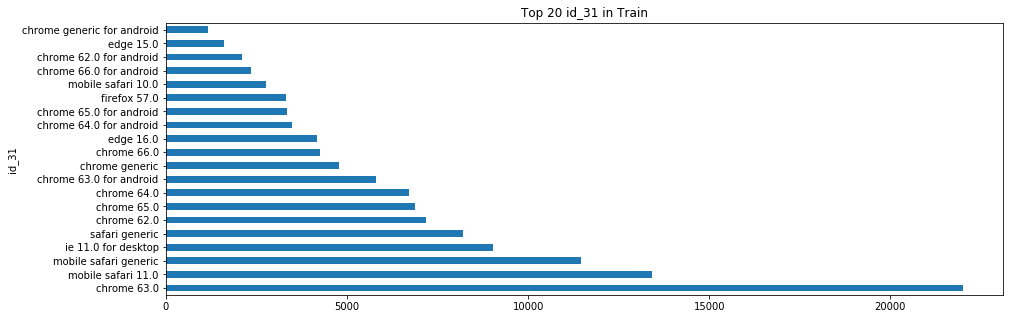

In [107]:
result_train.groupby('id_31') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 id_31 in Train')
plt.show()

In [0]:
result_train.id_31.value_counts()

chrome 63.0                   22000
mobile safari 11.0            13423
mobile safari generic         11474
ie 11.0 for desktop            9030
safari generic                 8195
chrome 62.0                    7182
chrome 65.0                    6871
chrome 64.0                    6711
chrome 63.0 for android        5806
chrome generic                 4778
chrome 66.0                    4264
edge 16.0                      4188
chrome 64.0 for android        3473
chrome 65.0 for android        3336
firefox 57.0                   3315
mobile safari 10.0             2779
chrome 66.0 for android        2349
chrome 62.0 for android        2097
edge 15.0                      1600
chrome generic for android     1158
firefox 59.0                   1099
samsung browser 6.2            1061
firefox 58.0                    833
chrome 49.0                     719
firefox                         673
ie 11.0 for tablet              647
chrome 61.0                     642
safari 11.0                 

In [0]:
result_train[['id_31_1', 'id_31_2', 'id_31_3', 'id_31_4']] = result_train['id_31'].str.split(' ', expand=True)
result_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,id_31_1,id_31_2,id_31_3,id_31_4
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,samsung,browser,6.2,None


In [0]:
result_train.id_31_1.value_counts()

chrome               76059
mobile               28379
ie                    9733
safari                8913
firefox               7012
edge                  6401
samsung               2044
opera                  449
android                386
other                  312
Samsung/SM-G532M       150
google                 146
Generic/Android        138
Samsung/SM-G531H        52
Microsoft/Windows       25
silk                    19
ZTE/Blade                9
line                     6
maxthon                  6
comodo                   6
aol                      5
Mozilla/Firefox          5
icedragon                5
Lanix/Ilium              3
waterfox                 2
puffin                   2
palemoon                 2
facebook                 2
Samsung/SCH              1
Cherry                   1
iron                     1
chromium                 1
LG/K-200                 1
Nokia/Lumia              1
BLU/Dash                 1
Inco/Minion              1
seamonkey                1
M

In [0]:
result_train.id_31_2.value_counts()

safari     28368
63.0       28028
generic    14319
65.0       10286
64.0       10230
11.0       10227
62.0        9340
66.0        6772
16.0        4188
57.0        3496
browser     2128
15.0        1600
59.0        1459
58.0        1283
61.0        1180
60.0         921
49.0         910
52.0         601
56.0         462
14.0         419
55.0         386
webview      285
48.0         179
51.0         150
50.0         145
10.0         111
search       110
53.0          88
54.0          82
7.0           81
17.0          74
43.0          72
46.0          69
13.0          62
9.0           43
47.0          37
67.0          34
mobile         1
69.0           1
Name: id_31_2, dtype: int64

In [0]:
result_train.id_31_3.value_counts()

for            31103
11.0           13423
generic        11684
10.0            2779
6.2             1061
9.0              541
6.4              509
4.0              422
application      110
7.0              101
uiwebview         97
8.0               54
5.4               43
5.2               41
4.2               18
3.3                8
61.0               1
Name: id_31_3, dtype: int64

In [0]:
result_train.id_31_4.value_counts()

android    20859
desktop     9030
tablet       647
ios          567
48.0          55
49.0          55
Name: id_31_4, dtype: int64

In [0]:
result_train.groupby("id_31").mean()["isFraud"]

id_31
BLU/Dash                   0.000000
Cherry                     0.000000
Generic/Android            0.122807
Generic/Android 7.0        0.197531
Inco/Minion                0.000000
LG/K-200                   0.000000
Lanix/Ilium                0.666667
M4Tel/M4                   0.000000
Microsoft/Windows          0.000000
Mozilla/Firefox            1.000000
Nokia/Lumia                0.000000
Samsung/SCH                0.000000
Samsung/SM-G531H           0.019231
Samsung/SM-G532M           0.113333
ZTE/Blade                  0.222222
android                    0.000000
android browser 4.0        0.150000
android webview 4.0        0.242105
aol                        0.000000
chrome                     0.079439
chrome 43.0 for android    0.263889
chrome 46.0 for android    0.231884
chrome 49.0                0.055633
chrome 49.0 for android    0.547170
chrome 50.0 for android    0.262069
chrome 51.0                0.035714
chrome 51.0 for android    0.111111
chrome 52.0 for androi

In [0]:
result_train.groupby("id_31_1").mean()["isFraud"]

id_31_1
BLU/Dash             0.000000
Cherry               0.000000
Generic/Android      0.166667
Inco/Minion          0.000000
LG/K-200             0.000000
Lanix/Ilium          0.666667
M4Tel/M4             0.000000
Microsoft/Windows    0.000000
Mozilla/Firefox      1.000000
Nokia/Lumia          0.000000
Samsung/SCH          0.000000
Samsung/SM-G531H     0.019231
Samsung/SM-G532M     0.113333
ZTE/Blade            0.222222
android              0.217617
aol                  0.000000
chrome               0.095952
chromium             0.000000
comodo               0.666667
cyberfox             0.000000
edge                 0.035151
facebook             0.000000
firefox              0.078152
google               0.020548
icedragon            1.000000
ie                   0.019110
iron                 0.000000
line                 0.000000
maxthon              0.000000
mobile               0.075514
opera                0.316258
other                0.195513
palemoon             0.000000
pu

In [0]:
result_train.groupby("id_31_2").mean()["isFraud"]

id_31_2
10.0       0.135135
11.0       0.019361
13.0       0.048387
14.0       0.059666
15.0       0.038125
16.0       0.027459
17.0       0.108108
43.0       0.263889
46.0       0.231884
47.0       0.081081
48.0       0.011173
49.0       0.123077
50.0       0.262069
51.0       0.133333
52.0       0.131448
53.0       0.022727
54.0       0.146341
55.0       0.113990
56.0       0.123377
57.0       0.054062
58.0       0.138737
59.0       0.070596
60.0       0.084691
61.0       0.094068
62.0       0.049358
63.0       0.077993
64.0       0.114076
65.0       0.114913
66.0       0.106172
67.0       0.264706
69.0       0.000000
7.0        0.197531
9.0        0.046512
browser    0.089756
generic    0.082757
mobile     0.000000
safari     0.075437
search     0.000000
webview    0.242105
Name: isFraud, dtype: float64

In [0]:
result_train.groupby("id_31_3").mean()["isFraud"]

id_31_3
10.0           0.046060
11.0           0.062728
3.3            0.000000
4.0            0.201422
4.2            0.111111
5.2            0.243902
5.4            0.302326
6.2            0.070688
6.4            0.076621
61.0           0.000000
7.0            0.069307
8.0            0.018519
9.0            0.029575
application    0.000000
for            0.094364
generic        0.100565
uiwebview      0.072165
Name: isFraud, dtype: float64

In [0]:
result_train.groupby("id_31_4").mean()["isFraud"]

id_31_4
48.0       0.000000
49.0       0.000000
android    0.129441
desktop    0.019380
ios        0.104056
tablet     0.001546
Name: isFraud, dtype: float64

SEEMS THAT id_31 is more informative and less confusing when not splitted, so del id_31_1 id_31_2 id_31_3 id_31_4

DO NOT FORGET TO DO TRAIN/TEST SPLIT BEFORE APPLYING AGGREGATIONS OR FREQUENCY ENC

In [19]:
test_range = len(result_train) - int(len(result_train) * 0.15)
test_range

501959

In [20]:
len(result_train),int(len(result_train) * 0.15),test_range+int(len(result_train) * 0.15)

(590540, 88581, 590540)

In [21]:
train_srt = result_train[:test_range]
test_srt = result_train[test_range:]
train_srt.shape,test_srt.shape

((501959, 446), (88581, 446))

group['cardX']['TransactionAmt'].mean/std

group['cardX']['dist1'].mean/std

group['cardX']['C1/13/14/11'].mean/std



In [22]:
aggreg_cols = ['TransactionAmt','cent_count','dollar','C1','C13','C14','C11','dist1']
group_cols = ['card1','card2','card3','card4','card5','card6']

for i in range(0,len(aggreg_cols)):
  for j in range(0,len(group_cols)):
    train_srt[aggreg_cols[i]+'_mean_'+group_cols[j]] = train_srt[aggreg_cols[i]] / train_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('mean')
    test_srt[aggreg_cols[i]+'_mean_'+group_cols[j]] = test_srt[aggreg_cols[i]] / test_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('mean')
    
    train_srt[aggreg_cols[i]+'std'+group_cols[j]] = train_srt[aggreg_cols[i]] / train_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('std')
    test_srt[aggreg_cols[i]+'std'+group_cols[j]] = test_srt[aggreg_cols[i]] / test_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('std')
    


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [112]:
train_srt.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,C13_mean_card5,C13stdcard5,C13_mean_card6,C13stdcard6,C14_mean_card1,C14stdcard1,C14_mean_card2,C14stdcard2,C14_mean_card3,C14stdcard3,C14_mean_card4,C14stdcard4,C14_mean_card5,C14stdcard5,C14_mean_card6,C14stdcard6,C11_mean_card1,C11stdcard1,C11_mean_card2,C11stdcard2,C11_mean_card3,C11stdcard3,C11_mean_card4,C11stdcard4,C11_mean_card5,C11stdcard5,C11_mean_card6,C11stdcard6,dist1_mean_card1,dist1stdcard1,dist1_mean_card2,dist1stdcard2,dist1_mean_card3,dist1stdcard3,dist1_mean_card4,dist1stdcard4,dist1_mean_card5,dist1stdcard5,dist1_mean_card6,dist1stdcard6
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.032753,0.008921,0.049498,0.007875,0.976744,2.424280,NaN,NaN,0.136015,0.030952,0.162233,0.023632,0.154096,0.047153,0.127590,0.015783,1.527273,3.309187,NaN,NaN,0.277743,0.045589,0.271284,0.032611,0.364055,0.112383,0.159724,0.016133,0.506667,0.374243,NaN,NaN,0.158764,0.051136,0.135016,0.047305,0.186864,0.07587,0.142850,0.046366
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.046031,0.007708,0.049498,0.007875,0.457887,0.146660,0.261868,0.030511,0.136015,0.030952,0.114701,0.018381,0.138639,0.016670,0.127590,0.015783,0.583984,0.178492,0.230074,0.020990,0.138872,0.022794,0.087081,0.009171,0.092418,0.008315,0.079862,0.008066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.029985,0.008791,0.027048,0.007406,0.112048,0.036709,0.139556,0.032986,0.136015,0.030952,0.117307,0.019818,0.130955,0.034916,0.113914,0.021186,0.121442,0.038536,0.141206,0.022285,0.138872,0.022794,0.094500,0.010309,0.143173,0.024923,0.097566,0.010970,3.601382,1.314031,2.294095,0.753291,2.398167,0.772417,2.294238,0.748357,2.380627,0.82372,2.442161,0.786120
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.652614,0.215880,0.676204,0.185145,0.117239,0.028898,0.127848,0.029585,0.136015,0.030952,0.114701,0.018381,0.124815,0.034074,0.113914,0.021186,0.117858,0.022485,0.128395,0.022625,0.138872,0.022794,0.087081,0.009171,0.135661,0.026847,0.097566,0.010970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.046031,0.007708,0.049498,0.007875,0.205479,0.230399,0.148541,0.022854,0.136015,0.030952,0.114701,0.018381,0.138639,0.016670,0.127590,0.015783,0.200000,0.237595,0.124942,0.015866,0.138872,0.022794,0.087081,0.009171,0.092418,0.008315,0.079862,0.008066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# ******group statistics******* for cent_count


train_srt['cent_count_mean_P_emaildomain_1'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_1'])['cent_count'].transform('mean')
train_srt['cent_count_mean_P_emaildomain_2'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_2'])['cent_count'].transform('mean')
train_srt['cent_count_mean_P_emaildomain_3'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_3'])['cent_count'].transform('mean')
train_srt['cent_count_mean_ProductCD'] = train_srt['cent_count'] / train_srt.groupby(['ProductCD'])['cent_count'].transform('mean')

train_srt['cent_count_std_P_emaildomain_1'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_1'])['cent_count'].transform('std')
train_srt['cent_count_std_P_emaildomain_2'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_2'])['cent_count'].transform('std')
train_srt['cent_count_std_P_emaildomain_3'] = train_srt['cent_count'] / train_srt.groupby(['P_emaildomain_3'])['cent_count'].transform('std')
train_srt['cent_count_std_ProductCD'] = train_srt['cent_count'] / train_srt.groupby(['ProductCD'])['cent_count'].transform('std')



test_srt['cent_count_mean_P_emaildomain_1'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_1'])['cent_count'].transform('mean')
test_srt['cent_count_mean_P_emaildomain_2'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_2'])['cent_count'].transform('mean')
test_srt['cent_count_mean_P_emaildomain_3'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_3'])['cent_count'].transform('mean')
test_srt['cent_count_mean_ProductCD'] = test_srt['cent_count'] / test_srt.groupby(['ProductCD'])['cent_count'].transform('mean')

test_srt['cent_count_std_P_emaildomain_1'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_1'])['cent_count'].transform('std')
test_srt['cent_count_std_P_emaildomain_2'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_2'])['cent_count'].transform('std')
test_srt['cent_count_std_P_emaildomain_3'] = test_srt['cent_count'] / test_srt.groupby(['P_emaildomain_3'])['cent_count'].transform('std')
test_srt['cent_count_std_ProductCD'] = test_srt['cent_count'] / test_srt.groupby(['ProductCD'])['cent_count'].transform('std')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [114]:

train_srt.groupby("addr2").mean()["cent_count"]


addr2
10.0     0.000000
13.0     2.428571
14.0     3.000000
15.0     3.000000
16.0     2.354167
17.0     0.000000
18.0     3.000000
19.0     0.909091
20.0     0.000000
21.0     3.000000
22.0     3.000000
23.0     0.000000
24.0     3.000000
25.0     3.000000
26.0     2.950000
27.0     0.277778
28.0     0.000000
29.0     0.545455
30.0     0.750000
31.0     2.531915
32.0     1.044944
34.0     0.214286
35.0     0.000000
36.0     0.000000
38.0     0.000000
39.0     0.000000
40.0     0.000000
43.0     0.428571
44.0     0.000000
46.0     0.000000
           ...   
62.0     0.000000
63.0     0.000000
65.0     0.472973
66.0     3.000000
68.0     0.000000
69.0     0.294118
70.0     0.000000
71.0     2.571429
72.0     2.333333
73.0     0.000000
74.0     0.000000
75.0     0.000000
76.0     0.000000
77.0     0.000000
78.0     2.000000
79.0     0.000000
82.0     0.000000
83.0     3.000000
84.0     0.000000
86.0     0.000000
87.0     0.790437
88.0     2.800000
89.0     0.000000
92.0     0.000000
94.0

In [115]:
train_srt.groupby("addr1").mean()["cent_count"]

addr1
100.0    2.884615
101.0    3.000000
102.0    2.615385
104.0    0.125000
105.0    1.333333
106.0    1.200000
110.0    1.299927
111.0    3.000000
112.0    3.000000
113.0    0.000000
117.0    3.000000
119.0    3.000000
120.0    3.000000
122.0    0.414478
123.0    0.727688
124.0    3.000000
125.0    1.000000
126.0    0.494166
127.0    3.000000
128.0    3.000000
129.0    3.000000
130.0    2.898204
131.0    3.000000
132.0    3.000000
133.0    3.000000
134.0    0.727273
137.0    3.000000
139.0    3.000000
141.0    2.500000
142.0    2.875000
           ...   
502.0    1.116147
503.0    2.000000
504.0    3.000000
505.0    3.000000
506.0    3.000000
507.0    3.000000
508.0    2.800000
509.0    0.666667
511.0    2.914474
512.0    0.623733
513.0    3.000000
514.0    3.000000
515.0    0.000000
516.0    3.000000
517.0    0.000000
518.0    3.000000
519.0    2.000000
520.0    2.961538
521.0    2.666667
522.0    0.000000
523.0    3.000000
526.0    3.000000
527.0    3.000000
528.0    3.000000
529.

In [24]:
train_srt['cent_count_mean_addr2'] = train_srt['cent_count'] / train_srt.groupby(['addr2'])['cent_count'].transform('mean')
train_srt['cent_count_std_addr2'] = train_srt['cent_count'] / train_srt.groupby(['addr2'])['cent_count'].transform('std')

test_srt['cent_count_mean_addr1'] = test_srt['cent_count'] / test_srt.groupby(['addr1'])['cent_count'].transform('mean')
test_srt['cent_count_std_addr2'] = test_srt['cent_count'] / test_srt.groupby(['addr2'])['cent_count'].transform('std')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [25]:
train_srt['cent_count_mean_addr1'] = train_srt['cent_count'] / train_srt.groupby(['addr1'])['cent_count'].transform('mean')
train_srt['cent_count_std_addr1'] = train_srt['cent_count'] / train_srt.groupby(['addr1'])['cent_count'].transform('std')


test_srt['cent_count_std_addr1'] = test_srt['cent_count'] / test_srt.groupby(['addr1'])['cent_count'].transform('std')
test_srt['cent_count_mean_addr2'] = test_srt['cent_count'] / test_srt.groupby(['addr2'])['cent_count'].transform('mean')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

group['addr1']['TransactionAmt'].mean/std

group['addr2']['TransactionAmt'].mean/std

group['addr1']['D15'].mean/std

group['addr2']['D15'].mean/std

group['addr1'][''C1/13/14/11''].mean/std

group['addr2'][''C1/13/14/11''].mean/std

=========================>

In [26]:
aggreg_cols = ['TransactionAmt','D15','C1','C13','C14','C11','dist1']
group_cols = ['addr1','addr2']

for i in range(0,len(aggreg_cols)):
  for j in range(0,len(group_cols)):
    train_srt[aggreg_cols[i]+'_mean_'+group_cols[j]] = train_srt[aggreg_cols[i]] / train_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('mean')
    test_srt[aggreg_cols[i]+'_mean_'+group_cols[j]] = test_srt[aggreg_cols[i]] / test_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('mean')
    
    train_srt[aggreg_cols[i]+'_std_'+group_cols[j]] = train_srt[aggreg_cols[i]] / train_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('std')
    test_srt[aggreg_cols[i]+'_std_'+group_cols[j]] = test_srt[aggreg_cols[i]] / test_srt.groupby([group_cols[j]])[aggreg_cols[i]].transform('std')
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [131]:
train_srt.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,cent_count_mean_P_emaildomain_1,cent_count_mean_P_emaildomain_2,cent_count_mean_P_emaildomain_3,cent_count_mean_ProductCD,cent_count_std_P_emaildomain_1,cent_count_std_P_emaildomain_2,cent_count_std_P_emaildomain_3,cent_count_std_ProductCD,cent_count_mean_addr2,cent_count_std_addr2,cent_count_mean_addr1,cent_count_std_addr1,TransactionAmt_mean_addr1,TransactionAmt_std_addr1,TransactionAmt_mean_addr2,TransactionAmt_std_addr2,D15_mean_addr1,D15_std_addr1,D15_mean_addr2,D15_std_addr2,C1_mean_addr1,C1_std_addr1,C1_mean_addr2,C1_std_addr2,C13_mean_addr1,C13_std_addr1,C13_mean_addr2,C13_std_addr2,C14_mean_addr1,C14_std_addr1,C14_mean_addr2,C14_std_addr2,C11_mean_addr1,C11_std_addr1,C11_mean_addr2,C11_std_addr2,dist1_mean_addr1,dist1_std_addr1,dist1_mean_addr2,dist1_std_addr2
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.060982,NaN,NaN,NaN,1.023253,1.265122,1.041669,0.953738,1.014863,0.508531,0.285723,0.466453,0.273594,0.000000,0.000000,0.000000,0.000000,0.125919,0.028716,0.105614,0.020098,0.033827,0.010111,0.031312,0.009523,0.154790,0.041850,0.137312,0.03239,0.343014,0.074978,0.286717,0.052066,0.288387,0.087234,0.158446,0.051011
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.185458,0.115666,0.197477,0.115828,0.000000,0.000000,0.000000,0.000000,0.119677,0.022612,0.105614,0.020098,0.034887,0.010793,0.031312,0.009523,0.155904,0.036245,0.137312,0.03239,0.162064,0.029249,0.143359,0.026033,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.442739,0.250097,0.401763,0.235650,1.663090,1.523036,1.769586,1.562002,0.116720,0.022729,0.105614,0.020098,0.030921,0.009973,0.031312,0.009523,0.148302,0.035919,0.137312,0.03239,0.159619,0.029461,0.143359,0.026033,3.962793,1.037579,2.393376,0.770528
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.370378,0.233806,0.340477,0.199704,0.701066,0.590270,0.623569,0.550420,0.255337,0.040402,0.211227,0.040196,0.949407,0.261321,0.782798,0.238073,0.167838,0.033840,0.137312,0.03239,0.169567,0.025935,0.143359,0.026033,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.309148,0.195589,0.340477,0.199704,NaN,NaN,NaN,NaN,0.139484,0.018281,0.105614,0.020098,0.053478,0.012915,0.031312,0.009523,0.197957,0.033022,0.137312,0.03239,0.186637,0.023399,0.143359,0.026033,NaN,NaN,NaN,NaN


----FREQUENCY ENCODING FEATURES---- 

In [27]:
frequency_cols = ['card1','card2','card3','card4','card5','card6','card1_card2_card3_card5','card1_card2',
                  'P_emaildomain_1','P_emaildomain_2','P_emaildomain_3','R_emaildomain_1',
                  'R_emaildomain_2','R_emaildomain_3','ProductCD','M6','M5','M4','DeviceInfo','DeviceType']

for col in frequency_cols:
  temp = train_srt[col].value_counts().to_dict()
  train_srt[col+'_counts'] = train_srt[col].map(temp)
  
  temp = test_srt[col].value_counts().to_dict()
  test_srt[col+'_counts'] = test_srt[col].map(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [28]:
train_srt.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,C1_mean_addr1,C1_std_addr1,C1_mean_addr2,C1_std_addr2,C13_mean_addr1,C13_std_addr1,C13_mean_addr2,C13_std_addr2,C14_mean_addr1,C14_std_addr1,C14_mean_addr2,C14_std_addr2,C11_mean_addr1,C11_std_addr1,C11_mean_addr2,C11_std_addr2,dist1_mean_addr1,dist1_std_addr1,dist1_mean_addr2,dist1_std_addr2,card1_counts,card2_counts,card3_counts,card4_counts,card5_counts,card6_counts,card1_card2_card3_card5_counts,card1_card2_counts,P_emaildomain_1_counts,P_emaildomain_2_counts,P_emaildomain_3_counts,R_emaildomain_1_counts,R_emaildomain_2_counts,R_emaildomain_3_counts,ProductCD_counts,M6_counts,M5_counts,M4_counts,DeviceInfo_counts,DeviceType_counts
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125919,0.028716,0.105614,0.020098,0.033827,0.010111,0.031312,0.009523,0.154790,0.041850,0.137312,0.03239,0.343014,0.074978,0.286717,0.052066,0.288387,0.087234,0.158446,0.051011,42,NaN,442646.0,5726.0,237.0,128201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370202,162879.0,111403.0,51213.0,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.119677,0.022612,0.105614,0.020098,0.034887,0.010793,0.031312,0.009523,0.155904,0.036245,0.137312,0.03239,0.162064,0.029249,0.143359,0.026033,NaN,NaN,NaN,NaN,598,2725.0,442646.0,160083.0,23757.0,128201.0,595.0,595.0,194644.0,399722.0,NaN,NaN,NaN,NaN,370202,162879.0,90396.0,165462.0,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.116720,0.022729,0.105614,0.020098,0.030921,0.009973,0.031312,0.009523,0.148302,0.035919,0.137312,0.03239,0.159619,0.029461,0.143359,0.026033,3.962793,1.037579,2.393376,0.770528,943,32222.0,442646.0,327825.0,48302.0,372885.0,940.0,940.0,4702.0,399722.0,NaN,NaN,NaN,NaN,370202,191428.0,111403.0,165462.0,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.255337,0.040402,0.211227,0.040196,0.949407,0.261321,0.782798,0.238073,0.167838,0.033840,0.137312,0.03239,0.169567,0.025935,0.143359,0.026033,NaN,NaN,NaN,NaN,3616,5257.0,442646.0,160083.0,21872.0,372885.0,3609.0,3609.0,87778.0,399722.0,NaN,NaN,NaN,NaN,370202,191428.0,90396.0,165462.0,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.139484,0.018281,0.105614,0.020098,0.053478,0.012915,0.031312,0.009523,0.197957,0.033022,0.137312,0.03239,0.186637,0.023399,0.143359,0.026033,NaN,NaN,NaN,NaN,15,12444.0,442646.0,160083.0,23757.0,128201.0,15.0,15.0,194644.0,399722.0,NaN,NaN,NaN,NaN,30462,NaN,NaN,NaN,9.0,47924.0


In [135]:
train_srt.iloc[0].DeviceType

nan

TO MODELLING WITH NEW FEATURES

In [29]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3','card1_card2_card3_card5','card1_card2','os', 'osV']

for col in cat_cols:
    if col in result_train.columns:
        lenc = LabelEncoder()
        lenc.fit(list(train_srt[col].astype(str).values) + list(test_srt[col].astype(str).values))
#         lenc.fit(list(train_srt[col].astype(str).values))
        train_srt[col] = lenc.transform(list(train_srt[col].astype(str).values))
        test_srt[col] = lenc.transform(list(test_srt[col].astype(str).values))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [30]:
train_srt = reduce_mem_usage(train_srt, verbose=True)
test_srt = reduce_mem_usage(test_srt, verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Mem. usage decreased to 2099.12 Mb (9.1% reduction)
Mem. usage decreased to 370.35 Mb (9.1% reduction)


In [0]:
X_train = train_srt.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = train_srt.sort_values('TransactionDT')['isFraud']

X_test = test_srt.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_test = test_srt.sort_values('TransactionDT')['isFraud']



In [32]:
model = lgb.LGBMClassifier()
start = timer()
model.fit(X_train, y_train)
train_time = timer() - start

predictions = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

columns = X_train.columns 
columns

The baseline score on the test set is 0.8743.
The baseline training time is 95.0981 seconds


Index(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'addr2',
       ...
       'P_emaildomain_3_counts', 'R_emaildomain_1_counts',
       'R_emaildomain_2_counts', 'R_emaildomain_3_counts', 'ProductCD_counts',
       'M6_counts', 'M5_counts', 'M4_counts', 'DeviceInfo_counts',
       'DeviceType_counts'],
      dtype='object', length=599)

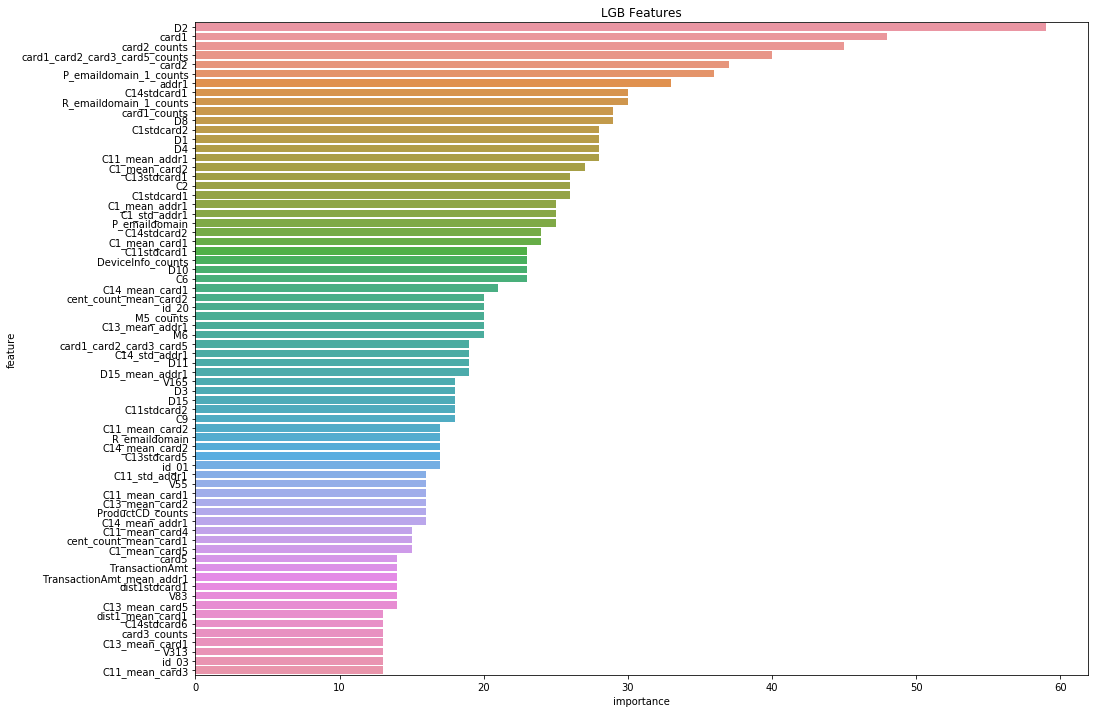

In [35]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = columns
feature_importance["importance"] = model.feature_importances_
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:70].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features');

should check accuracy after adding new set of features

In [0]:
# features to del
del_cols = []

HYPERPARAM TUNING 

In [0]:
MAX_EVALS = 500
N_FOLDS = 10

In [0]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

In [0]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

In [0]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

In [0]:
# Create a lgb dataset
train_set = lgb.Dataset(X_train, label = y_train)

In [0]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

In [0]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

In [0]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

In [0]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

In [0]:
random_results.loc[0, 'params']